In [35]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import RegressionResults
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
sns.set(style="ticks")
%matplotlib inline

In [2]:
nyc_cab_df = pd.read_csv('nyc_car_hire_data.csv', low_memory=False)

In [36]:
def train_test_split(df, n_samples, validation=False):
    if validation:
        nyc_cab_sample = df.sample(n=n_samples)

        nyc_cab_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
        nyc_cab_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)

        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        non_test = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]
        
        msk = np.random.rand(len(non_test)) < 0.7
        train = non_test[msk]
        validation = non_test[~msk]
        
        return train, validation, test
    
    else:
        nyc_cab_sample = df.sample(n=n_samples)

        nyc_cab_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
        nyc_cab_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)

        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        train = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]

        return train, test

---

## Dimensionality Reduction: PCA

In [55]:
train, validation, test = train_test_split(nyc_cab_df, 1000, validation=True)

y_train = train['Fare_amount'].values
y_val = validation['Fare_amount'].values
y_test = test['Fare_amount'].values

regression_model = LinearRegression(fit_intercept=True)

all_predictors = ['Trip Length (min)', 'Type', 'Trip_distance', 'TMAX', 'TMIN', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude', 'Pickup_latitude', 'SNOW', 'SNWD', 'PRCP']

train.describe()

,AWND,Day,Dropoff_latitude,Dropoff_longitude,Ehail_fee,Extra,Fare_amount,Lpep_dropoff_datetime,MTA_tax,PRCP,...,TMIN,Tip_amount,Tolls_amount,Total_amount,Trip_distance,Trip_type,Type,VendorID,lpep_pickup_datetime,Trip Length (min)
count,555.000000,555.000000,397.000000,397.000000,0.0,397.000000,555.000000,555.000000,397.000000,555.000000,...,555.000000,397.000000,397.000000,397.000000,555.000000,370.000000,555.000000,397.000000,555.000000,555.000000
mean,6.301261,15.544144,40.657118,-73.740833,NaN,0.360202,14.840373,13.706306,0.483627,0.304072,...,43.461261,0.970907,0.103224,14.302091,2.966048,1.016216,0.284685,1.780856,13.722523,11.745946
std,1.811899,8.811880,2.046459,3.710697,NaN,0.364079,8.991866,6.822284,0.089097,0.978401,...,5.772760,1.899930,0.790127,10.318883,2.440517,0.126477,0.451671,0.414188,6.732816,8.256622
min,2.000000,1.000000,0.000000,-74.194969,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,31.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,4.900000,8.000000,40.722504,-73.964455,NaN,0.000000,7.725177,9.000000,0.500000,0.000000,...,40.000000,0.000000,0.000000,8.000000,1.476206,1.000000,0.000000,2.000000,9.000000,7.000000
50%,6.000000,15.000000,40.756714,-73.938911,NaN,0.500000,13.000000,15.000000,0.500000,0.000000,...,43.000000,0.000000,0.000000,11.000000,2.342590,1.000000,0.000000,2.000000,15.000000,10.000000
75%,7.800000,24.000000,40.804909,-73.891899,NaN,0.500000,20.303457,19.000000,0.500000,0.070000,...,46.000000,1.400000,0.000000,17.500000,3.595000,1.000000,1.000000,2.000000,19.000000,14.000000
max,9.400000,30.000000,40.882172,0.000000,NaN,1.000000,73.500000,23.000000,0.500000,4.970000,...,59.000000,16.600000,9.000000,99.600000,19.740000,2.000000,1.000000,2.000000,23.000000,56.000000


### 1. Variable Selection: Backwards

In [38]:
def get_aic(X_train, y_train):
    X_train = add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    return model.aic

X_train = train[all_predictors].values
predictors = [(all_predictors, get_aic(X_train, y_train))]

for k in range(len(all_predictors), 1, -1):
    best_k_predictors = predictors[-1][0]
    aics = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = train[k_minus_1].values

        aics.append(get_aic(X_train, y_train))
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(aics)]]))
    predictors.append((best_k_minus_1, np.min(aics)))
    
best_predictor_set = sorted(predictors, key=lambda t: t[1])[-1]

In [39]:
best_predictor_set = sorted(predictors, key=lambda t: t[1])[0]

X_train = train[best_predictor_set[0]].values
X_val = validation[best_predictor_set[0]].values  
X_test = test[best_predictor_set[0]].values  
regression_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print('best predictor set: {}\ntest R^2: {}'.format(best_predictor_set[0], regression_model.score(X_test, y_test)))

best predictor set: ['Type', 'SNOW', 'Lpep_dropoff_datetime', 'SNWD', 'Trip_distance', 'Trip Length (min)']
test R^2: 0.613997587194766


## 2. Variable Selection: LASSO Regression

In [40]:
X_train = train[all_predictors].values
X_val = validation[all_predictors].values
X_non_test = np.vstack((X_train, X_val))
X_test = test[all_predictors].values

y_non_test = np.hstack((y_train, y_val))

lasso_regression = Lasso(alpha=1.0, fit_intercept=True)
lasso_regression.fit(X_non_test, y_non_test)

print('Lasso regression model:\n {} + {}^T . x'.format(lasso_regression.intercept_, lasso_regression.coef_))



Lasso regression model:
 4.718051298020281 + [ 0.32545776  4.82421529  1.73898646  0.          0.         -0.
 -0.00684636  0.         -0.          0.          0.          0.        ]^T . x


,AWND,Day,Dropoff_latitude,Dropoff_longitude,Ehail_fee,Extra,Fare_amount,Lpep_dropoff_datetime,MTA_tax,PRCP,...,TMIN,Tip_amount,Tolls_amount,Total_amount,Trip_distance,Trip_type,Type,VendorID,lpep_pickup_datetime,Trip Length (min)
count,563.000000,563.000000,382.000000,382.000000,0.0,382.000000,563.000000,563.000000,382.000000,563.000000,...,563.000000,382.000000,382.000000,382.000000,563.000000,353.000000,563.000000,382.000000,563.000000,563.000000
mean,6.295915,15.884547,40.758286,-73.933923,NaN,0.393979,14.486707,13.712256,0.484293,0.313375,...,43.358792,1.179607,0.145916,13.872644,2.786539,1.025496,0.321492,1.801047,13.873890,10.763766
std,1.793266,8.932875,0.057298,0.047643,NaN,0.376321,8.727789,6.738822,0.087331,1.030186,...,5.660867,2.409299,0.860186,9.865012,2.278020,0.157849,0.467464,0.399736,6.582902,7.868309
min,2.000000,1.000000,40.588928,-74.036293,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,31.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,4.900000,8.000000,40.718020,-73.967112,NaN,0.000000,7.000000,9.000000,0.500000,0.000000,...,40.000000,0.000000,0.000000,7.500000,1.260000,1.000000,0.000000,2.000000,9.000000,6.000000
50%,5.800000,16.000000,40.755747,-73.942505,NaN,0.500000,12.500000,15.000000,0.500000,0.000000,...,43.000000,0.000000,0.000000,10.225000,2.150000,1.000000,0.000000,2.000000,15.000000,9.000000
75%,8.300000,24.000000,40.804507,-73.906462,NaN,0.500000,20.989595,19.000000,0.500000,0.050000,...,46.000000,1.895000,0.000000,16.787500,3.600677,1.000000,1.000000,2.000000,19.000000,13.000000
max,9.400000,30.000000,40.911869,-73.783318,NaN,1.000000,52.000000,23.000000,0.500000,4.970000,...,59.000000,21.000000,5.330000,68.250000,17.500000,2.000000,1.000000,2.000000,23.000000,50.000000


In [41]:
print('Test R^2: {}'.format(lasso_regression.score(X_test, y_test)))

Test R^2: 0.5640977221609269


### 3. Principal Component Regression

In [42]:
pca = PCA(n_components=4)
pca.fit(X_non_test)
X_non_test_pca = pca.transform(X_non_test)
X_test_pca = pca.transform(X_test)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [ 0.35266104  0.30974822  0.23533029  0.04614604]


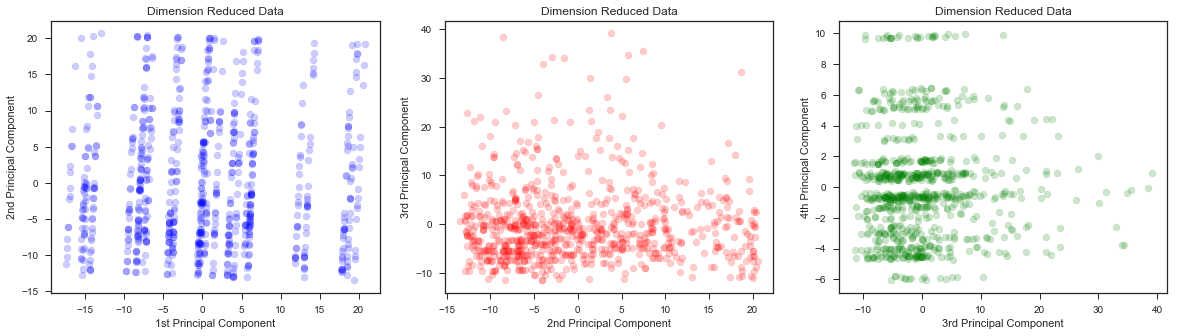

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].scatter(X_non_test_pca[:, 0], X_non_test_pca[:, 1], color='blue', alpha=0.2, label='train R^2')

ax[0].set_title('Dimension Reduced Data')
ax[0].set_xlabel('1st Principal Component')
ax[0].set_ylabel('2nd Principal Component')

ax[1].scatter(X_non_test_pca[:, 1], X_non_test_pca[:, 2], color='red', alpha=0.2, label='train R^2')

ax[1].set_title('Dimension Reduced Data')
ax[1].set_xlabel('2nd Principal Component')
ax[1].set_ylabel('3rd Principal Component')

ax[2].scatter(X_non_test_pca[:, 2], X_non_test_pca[:, 3], color='green', alpha=0.2, label='train R^2')

ax[2].set_title('Dimension Reduced Data')
ax[2].set_xlabel('3rd Principal Component')
ax[2].set_ylabel('4th Principal Component')

plt.show()

In [44]:
print('first pca component:', pca.components_[0])
print('\nsecond pca component:', pca.components_[1])
print('\nthird pca component:', pca.components_[2])
print('\nfourth pca component:', pca.components_[3])

first pca component: [-0.00535566 -0.0024424   0.00535312  0.84837581  0.52686147 -0.0347733
 -0.02516945 -0.0151692   0.00857694 -0.         -0.         -0.02158279]

second pca component: [ -2.78996297e-02  -7.78645860e-04  -8.41287443e-04  -4.07707358e-02
  -1.39591187e-02  -6.97761616e-01  -7.14020027e-01   2.26866742e-02
  -1.23425543e-02   0.00000000e+00   0.00000000e+00  -5.39458392e-04]

third pca component: [ 0.96942319 -0.00574121  0.24273353 -0.00318404  0.00956019 -0.01553881
 -0.02365233 -0.01653702  0.00871489  0.          0.         -0.0037816 ]

fourth pca component: [ 0.00906176 -0.00097938  0.00496818  0.52618728 -0.84884713 -0.01894907
  0.00571241  0.02344169 -0.01339048  0.          0.         -0.03684045]


In [45]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_non_test_pca, y_non_test)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: 0.2867990583026705


### 3. Principal Component Regression With Polynomial and Interaction Terms

In [46]:
gen_poly_terms = PolynomialFeatures(degree=6, interaction_only=False)

min_max_scaler = MinMaxScaler()
X_non_test = min_max_scaler.fit_transform(X_non_test)
X_test = min_max_scaler.fit_transform(X_test)

X_train_full_poly = gen_poly_terms.fit_transform(X_non_test)
X_test_full_poly = gen_poly_terms.fit_transform(X_test)

print('number of total predictors', X_train_full_poly.shape[1])

number of total predictors 18564


In [47]:
pca = PCA(n_components=15)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [ 0.35464084  0.25203523  0.14403337  0.06464052  0.03057768  0.02686149
  0.0234663   0.01698414  0.01288877  0.01112968  0.00834928  0.00610953
  0.00562714  0.00519129  0.00386799]


In [48]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: 0.5393636355874347


In [49]:
pca = PCA(n_components=45)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [  3.54640840e-01   2.52035233e-01   1.44033366e-01   6.46405244e-02
   3.05776837e-02   2.68614888e-02   2.34663024e-02   1.69841411e-02
   1.28887651e-02   1.11296789e-02   8.34928245e-03   6.10953399e-03
   5.62714043e-03   5.19129406e-03   3.86799024e-03   3.43133791e-03
   3.08965850e-03   2.37287925e-03   2.28753078e-03   2.18918876e-03
   2.13384153e-03   1.80170559e-03   1.59511606e-03   1.35052783e-03
   1.18886197e-03   1.09513688e-03   9.56049716e-04   8.10425592e-04
   7.81231273e-04   6.72013350e-04   6.22551371e-04   6.00057274e-04
   4.38652587e-04   4.11883879e-04   4.07211026e-04   3.54631015e-04
   3.40884616e-04   3.02147913e-04   2.72643412e-04   2.59783246e-04
   2.39834877e-04   2.12233315e-04   2.01769670e-04   2.00545384e-04
   1.86754908e-04]


In [50]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: 0.5756401842246859


---

## Selecting the Components of PCA Using Cross Validation

In [51]:
regression_model = LinearRegression(fit_intercept=True)
kf = KFold(n_splits=5)

x_val_scores = []

for n in range(1, 80, 5):
    out = n * 1. / 80 * 100
    sys.stdout.write("\r%d%%" % out)
    sys.stdout.flush()
    
    pca = PCA(n_components=15)
    pca.fit(X_train_full_poly)
    
    validation_R_sqs = []
    for train_index, val_index in kf.split(X_train_pca):
        X_train, X_val = X_train_full_poly[train_index], X_train_full_poly[val_index]
        y_train, y_val = y_non_test[train_index], y_non_test[val_index]

        X_train_pca = pca.transform(X_train)
        X_val_pca = pca.transform(X_val)
        
        regression_model.fit(X_train_pca, y_train)
        validation_R_sqs.append(regression_model.score(X_val_pca, y_val))
        
    x_val_scores.append(np.mean(validation_R_sqs))
    
sys.stdout.write("\r%d%%" % 100)

100%

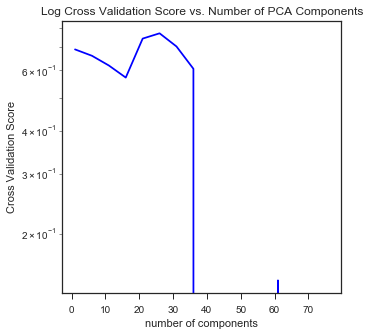

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(range(1, 80, 5), x_val_scores, color='blue')

ax.set_title('Log Cross Validation Score vs. Number of PCA Components')
ax.set_xlabel('number of components')
ax.set_ylabel('Cross Validation Score')
ax.set_yscale('log')

plt.show()

In [54]:
best_n = range(1, 80, 5)[np.argmax(x_val_scores)]

pca = PCA(n_components=best_n)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

regression_model.fit(X_train_pca, y_non_test)
test_R_sq = regression_model.score(X_test_pca, y_test)

print('best regularization param is:', best_n)
print('the test R^2 for PC regression with n = {} is: {}'.format(best_n, test_R_sq))

best regularization param is: 26
the test R^2 for PC regression with n = 26 is: 0.5911750507980804
